## Datasets and Dataloaders

* torch.utils.data.Dataset : holds the samples and the targets. Implements dataset-specific funcs.

* torch.utils.data.Dataloader : an iterable wrapper around the Dataset object. Specifies the number of threads and the on-the-go transforms to be applied to data and the labels.

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor 
import matplotlib.pyplot as plt

**Note that the data downloads as PIL Image for the FashionMNIST dataset, but to train on PyTorch, it needs to be stored in a torch.Tensor object. ToTensor() is the transformation that does that.**

In [2]:
training_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True, 
    transform = ToTensor()
)


58.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.6%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



119.3%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



torch.Size([1, 28, 28]) torch.Size([28, 28])
torch.Size([1, 28, 28]) torch.Size([28, 28])
torch.Size([1, 28, 28]) torch.Size([28, 28])
torch.Size([1, 28, 28]) torch.Size([28, 28])
torch.Size([1, 28, 28]) torch.Size([28, 28])
torch.Size([1, 28, 28]) torch.Size([28, 28])
torch.Size([1, 28, 28]) torch.Size([28, 28])
torch.Size([1, 28, 28]) torch.Size([28, 28])
torch.Size([1, 28, 28]) torch.Size([28, 28])


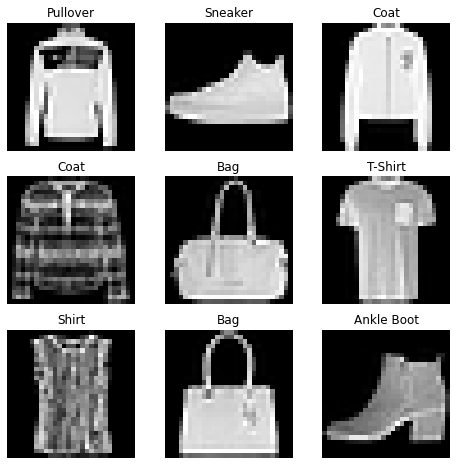

In [6]:
labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover', 
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt', 
    7: 'Sneaker', 
    8: 'Bag',
    9: 'Ankle Boot'
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3 
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()

### Custom Dataset Object for your own data ###

In [16]:
#Interface requires you implement at least init, getitem and len functions.

import os 
import pandas as pd 
from torchvision.io import read_image 

class CustomFashionMNIST(Dataset):
    
    #constructor. 
    def __init__(self, labels_path, imgs_path, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_path) # assuming the annotations are in csv file.
        self.img_dir = imgs_path
        self.transform = transform
        self.target_transform = target_transform  
        
    def __len__(self):
        return len(self.img_labels)
    
    #This is the most important method. This method loads the sample from storage into memory.
    #It should apply the transforms onto the label and the sample.
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) # utility function to read .jpg into pytorch tensor.
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image) # very handy, Transform object has __call__ method.
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

### The DataLoader Wrapper ### 

**Function: Wrapper around the Dataset object to manage minibatch loading (takes batch size as argument), multiprocessing for data retrieval (num_workers), shuffling of the dataset at each epoch etc.**

* Note: It is still the job of the __getitem__ of the Dataset object to apply the transforms. It is not the Dataloader.

In [49]:
from torch.utils.data import DataLoader

'''
Syntax: Dataloader(dataset_obj, 
                   batch_size, 
                   shuffle, 
                   pin_memory,
                   drop_last, 
                   timeout,
                   num_workers
                )
'''

train_dataloader = DataLoader(training_data, 
                              batch_size = 64, 
                              shuffle=True, #order of samples will change each epoch.
                              drop_last = True, #TF: drop_remainder
                              num_workers = 6)

test_dataloader = DataLoader(test_data, 
                             batch_size=64, 
                             drop_last = True,
                             num_workers= 6) 


### Iterating over the DataLoader. ###

Text(0.5, 1.0, 'tensor(0)')

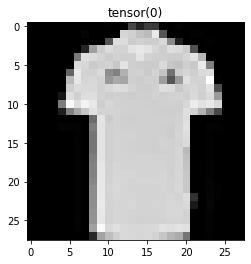

In [50]:
img_batch, label_batch = next(iter(train_dataloader))
#display an image from the batch with its label. 
img = img_batch[0].squeeze() 
label = label_batch[0]
plt.imshow(img, cmap='gray')
plt.title(label)


## Transforms  ### 

In [51]:
from torchvision.transforms import Lambda 

ds = datasets.FashionMNIST(
    root = 'data',
    train=True,
    download = True,
    transform = ToTensor(), #applied to the features. PIL Image -> Torch tensor.
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0,
                                                                                   torch.tensor(y), 
                                                                                    value = 1))
)